In [1]:
import os, sys
import torch
import pickle
import numpy as np
from scipy.misc import imsave, imshow
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from torch.autograd import Variable
import math
import torch
import seaborn as sns
from matplotlib import offsetbox

In [2]:
import os
import sys
import inspect
_parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(
    os.path.abspath(inspect.getfile(inspect.currentframe())))))
sys.path.insert(0, _parent_dir)

In [3]:
import pandas as pd
from dqn.utils.io import read_json, read_pickle
from dqn.utils.plot import plot_state
from dqn.utils.math import boltzmann
from dqn.teacher.snapshots_teacher import SnapshotsTeacher
from matplotlib.ticker import FuncFormatter
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.colors as colors
from IPython.display import Image
from tensorboardX import SummaryWriter
import scipy
sns.set_style("darkgrid")
%load_ext autoreload
%autoreload 2

In [4]:
def millions(x, pos):
    return '%1.1fM' % (x*1e-6)
million_formatter = FuncFormatter(millions)
def hundreds(x, pos):
    return int(x)
int_formatter = FuncFormatter(hundreds)

In [5]:
def load_summary_data(exp_path, train=True):
    _summary_flag = "training" if train else "testing"
    summary = pd.read_json(os.path.join(exp_path, "episodes", 
                                        _summary_flag + "_summary.txt"), orient="index")
    summary.index = summary.index.map(int)
    summary.sort_index(inplace=True)
    summary["cum_steps"] = summary["steps"].cumsum()
    return summary

In [6]:
def find_episode_with_highest_rewards(train_summary):
    _episode = train_summary.iloc[train_summary["total_rew"].idxmax()]
    print(_episode)
    return _episode.name

In [7]:
def load_episode(episode_num):
    summary = pd.read_pickle(os.path.join(exp_path, "episodes", 
                                          "episode_train_color_{0}.pkl".format(episode_num)))
    return summary

In [8]:
def display_episode(episode):
    gif_location = os.path.join(exp_path, "episodes")
    episode.to_animation(gif_location)
    with open(os.path.join(gif_location, "episode_train_{0}.gif".format(episode.episode_num)),'rb') as f:
        display(Image(data=f.read(), format='png'))

In [9]:
def plot_one_history(ax, data, y, title, x="steps", window=100, alpha_fill=0.2):
    _y = data[y]
    assert len(_y) > window
    if x == "steps":
        _x = data["cum_steps"]
    else:
        _x = data.index
    _error = _y.rolling(window=window, min_periods=1, center=False).std()
    _smooth = _y.rolling(window=window, min_periods=1, center=False).mean()
    ymin = _smooth - _error
    ymax = _smooth + _error
    ax.plot(_x, _smooth)
    ax.fill_between(_x, ymax, ymin, alpha=alpha_fill)

In [10]:
def plot_histories(summaries, y, title, x="steps", window=20, alpha_fill=0.2):
    ax = plt.gca()
    legends = []
    for summary, legend in summaries:
        plot_one_history(ax, summary, y, title, x=x, window=window, alpha_fill=alpha_fill)
        legends.append(legend)
    if x == "steps":
        _x = summaries[0][0]["cum_steps"]
        _formater = million_formatter
    else:
        _x = summaries[0][0].index
        _formater = int_formatter
    ax.xaxis.set_major_formatter(_formater)
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.legend(legends, loc='best')
    plt.show()

In [11]:
exp_path = "../runs/pong_standard_fast_(1)"
# exp_path_snapshot = "../runs/pong_snapshot_fast_(3)"

In [12]:
train_summary = load_summary_data(exp_path, train=True)
test_summary = load_summary_data(exp_path, train=False)
# train_summary_snapshot = load_summary_data(exp_path_snapshot, train=True)

In [13]:
# plot_histories(
#     [(train_summary, "Without Teacher"), 
#      (train_summary_snapshot, "With Teacher Snapshots")],
#     y="total_rew", 
#     title="Training Rewards (Pong)")

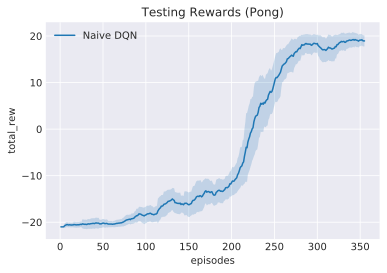

In [13]:
plot_histories(
    [(test_summary, "Naive DQN")],
    x="episodes",
    y="total_rew", 
    title="Testing Rewards (Pong)")

In [14]:
snapshots_summary = read_json(os.path.join(exp_path, "snapshots"), "snapshots_summary.txt")

In [47]:
SCALE = [0.2, 0.6, 1, 1.4, 1.8]
def _plot_transition(ax, states, title="Transition"):
    canvas = np.zeros((states.shape[1], states.shape[2], states.shape[3]))
    for j in range(5):
        canvas += states[j] * SCALE[j]
    canvas = canvas / 5 / 255
    ax.axis('off')
    ax.imshow(canvas, cmap='gray')
    ax.set_title(title)

In [86]:
def plot_transition(episode_num, index, title="Transition", ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(3, 5))
    _episode = load_episode(episode_num)
    _plot_transition(ax, _episode.states[index+2:index+7], title)
#     plt.show()

In [297]:
def plot_transitions(rewards, idxes, values, n=4):
    f, ax = plt.subplots(int(n/4) * 2, n, figsize=(3 * 4, int(n/4) * 7))
    plt.suptitle("Sample Transitions Matching Rewards {0}".format(rewards))
    for j in range(0, n):
        title_bottom = "Bottom #{0} (score {1:.2f})".format(abs(j+1), values[idxes[j]])
        idx_top = (j + 1) * -1
        title_top = "Top #{0} (score {1:.2f})".format(abs(j+1), values[idxes[idx_top]])
        _episode_num, _frame_num = teacher._replay._frame_lookup[idxes[j]]
        plot_transition(_episode_num, _frame_num, title=title_bottom, ax=ax[1, j])
        _episode_num, _frame_num = teacher._replay._frame_lookup[idxes[idx_top]]
        plot_transition(_episode_num, _frame_num, title=title_top, ax=ax[0, j])
    plt.subplots_adjust(wspace=0.05, hspace=0, top=0.925, bottom=0)
    plt.savefig("{0}_{1}_transitions.pdf".format(snapshot_params["teacher"]["progress_measure"], rewards), format='pdf', dpi=300)
    plt.close()
    #     plt.show()

In [18]:
default_params = read_json(os.path.join(exp_path, "..", "..", "settings"), "global_settings")

In [19]:
snapshot_params = read_json(os.path.join(exp_path, "..", "..", "settings"), "pong_snapshot_fast")

In [20]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Initialize Snapshot Teacher

In [205]:
writer = SummaryWriter(log_dir="tmp", comment=None)

In [213]:
snapshot_params["teacher"]

{'type': 'snapshots',
 'progress_measure': 'cosine',
 'models': ['pong_standard_fast_(1)'],
 'batch_size': 128,
 'num_snapshot_ahead': 5,
 'num_episode_around': 5,
 'negative_correction': False,
 'replay_size': 1000000,
 'temperature': 0.0001,
 'progress_epsilon': 1e-06,
 'blend': {'frames': 100000, 'start': 0.1, 'end': 0.75},
 'supervise_loss': {'type': 'margin',
  'enabled': True,
  'lambda': 0.01,
  'margin': 0.8,
  'sample_enabled': False}}

In [298]:
snapshot_params["teacher"]["progress_measure"] = "cosine"

In [294]:
snapshot_params["teacher"]["progress_measure"] = "projection"

In [299]:
teacher = SnapshotsTeacher(
    writer=writer,
    model_name="../" + exp_path, teacher_num=0, train_params=default_params["train"],
    gpu_params=default_params["gpu"], teacher_params=snapshot_params["teacher"], 
    env_params=default_params["env"], log_params=default_params["log"], debug_dir="tmp",
    opt_params=default_params["opt"])

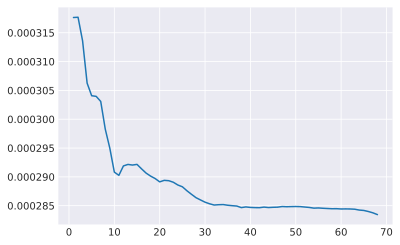

In [63]:
_weight_by_gap = []
for i in range(1, teacher._snapshots.df_length):
    a, b, c = teacher._check_snapshots_direction(start_num=1, num_gaps=i)
    _weight_by_gap.append(a/b/c)
plt.plot(range(1, teacher._snapshots.df_length), _weight_by_gap)
plt.show()

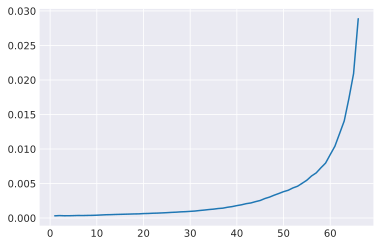

In [59]:
_weight_by_snapshot = []
_range = range(1, teacher._snapshots.df_length-2)
for i in _range:
    a, b, c = teacher._check_snapshots_direction(start_num=i, num_gaps=2)
    _weight_by_snapshot.append(a/b/c)
plt.plot(_range, _weight_by_snapshot)

# T-SNE visualization

In [308]:
perp = []
# snapshot_params["teacher"]["progress_measure"] = "cosine"
snapshot_params["teacher"]["progress_measure"] = "projection"
teacher = SnapshotsTeacher(
    writer=writer,
    model_name="../" + exp_path, teacher_num=0, train_params=default_params["train"],
    gpu_params=default_params["gpu"], teacher_params=snapshot_params["teacher"], 
    env_params=default_params["env"], log_params=default_params["log"], debug_dir="tmp",
    opt_params=default_params["opt"])
for matching_rewards in [-20, -10, 0, 10]:
    teacher.matching(matching_rewards, 0)
    progrss_scores = teacher._replay.info["progress_scores"]
    progrss_scores_idx = progrss_scores.argsort()
    plot_transitions(matching_rewards, progrss_scores_idx, progrss_scores, n=4)
    plt.hist(progrss_scores, bins=30, 
         range=(np.percentile(progrss_scores, 90), np.percentile(progrss_scores, 100)))
    plt.title("Top Tail Progress Score Distribution (90% - 100%)"
              .format(matching_rewards, np.mean(progrss_scores), np.std(progrss_scores)))
    plt.savefig("{0}_{1}_top_dist.pdf".format(snapshot_params["teacher"]["progress_measure"], matching_rewards), format='pdf', dpi=300)
    plt.close()
    plt.hist(progrss_scores, bins=30, 
             range=(np.percentile(progrss_scores, 5), np.percentile(progrss_scores, 95)))
    plt.title("Progress Score Distribution Around Reward {0}: mean {1:.2f}, std {2:.2f}"
              .format(matching_rewards, np.mean(progrss_scores), np.std(progrss_scores)))
    plt.savefig("{0}_{1}_dist.pdf".format(snapshot_params["teacher"]["progress_measure"], matching_rewards), format='pdf', dpi=300)
    plt.close()

    n_samples_tsne = 1000
    _mid_point = int(len(progrss_scores_idx) / 2)
    _left_mid_point = _mid_point - int(n_samples_tsne / 2)
    _right_mid_point = _mid_point + int(n_samples_tsne / 2)
    tsne_sample_idx = progrss_scores_idx[
        np.r_[0:n_samples_tsne, _left_mid_point:_right_mid_point,
              (-n_samples_tsne):0]]


    pca = PCA(n_components=50)
    embeddings = pca.fit_transform(teacher._replay.info["activations"][tsne_sample_idx])

    tsne_embeddings = TSNE(n_components=2, perplexity=40).fit_transform(embeddings)

    _progress_scores = progrss_scores[tsne_sample_idx]
    min_score = int(np.min(_progress_scores))
    max_score = int(np.max(_progress_scores))

    plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], 0.3, 
                c=_progress_scores, 
                norm=MidpointNormalize(midpoint=0),
                cmap='bwr')
    plt.colorbar()
    plt.savefig("{0}_{1}_tsne.pdf".format(snapshot_params["teacher"]["progress_measure"], matching_rewards), format='pdf', dpi=300)
    plt.close()
    
    perp_fnx = lambda x: np.exp(scipy.stats.entropy(x)) / len(x)
    perp.append((perp_fnx(teacher._replay.info["p"]), matching_rewards))

plt.figure(figsize=(5,2))
plt.plot([i[1] for i in perp], [i[0] for i in perp])
plt.title("Relative Perplexity of Sample Distribution")
plt.savefig("{0}_relative_perplexity.pdf".format(snapshot_params["teacher"]["progress_measure"]), format='pdf', dpi=300)
plt.close()

In [273]:
progrss_scores = teacher._replay.info["progress_scores"]
progrss_scores_idx = progrss_scores.argsort()
# _progress_scores = _score_fnc(teacher._replay.info, "progress_scores")
# _p = np.power(_progress_scores, teacher._replay_params["alpha"])
# teacher._replay.info["p"] = _p / _p.sum()

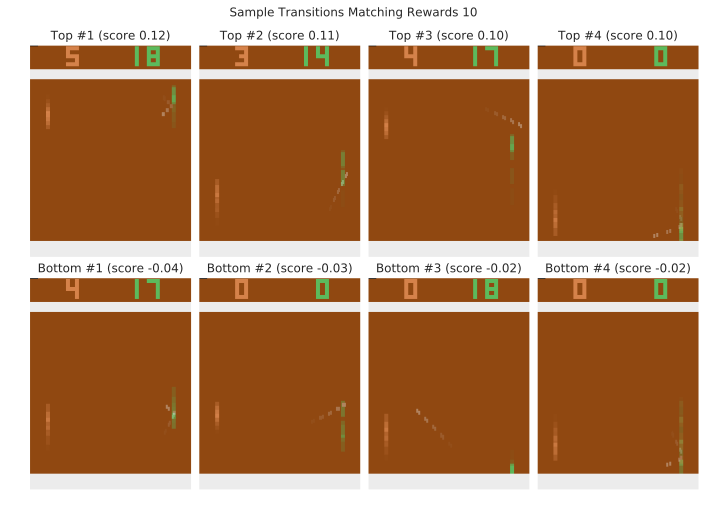

In [274]:
plot_transitions(matching_rewards, progrss_scores_idx, progrss_scores, n=4)

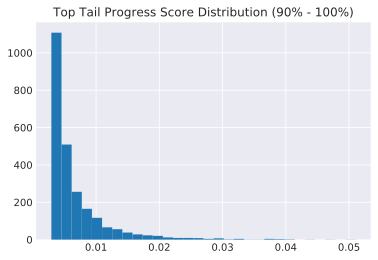

In [32]:
plt.hist(progrss_scores, bins=30, 
         range=(np.percentile(progrss_scores, 90), np.percentile(progrss_scores, 100)))
plt.title("Top Tail Progress Score Distribution (90% - 100%)"
          .format(matching_rewards, np.mean(progrss_scores), np.std(progrss_scores)))
plt.show()

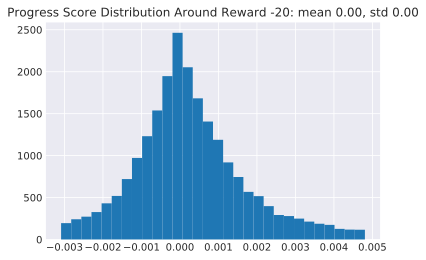

In [33]:
plt.hist(progrss_scores, bins=30, 
         range=(np.percentile(progrss_scores, 5), np.percentile(progrss_scores, 95)))
plt.title("Progress Score Distribution Around Reward {0}: mean {1:.2f}, std {2:.2f}"
          .format(matching_rewards, np.mean(progrss_scores), np.std(progrss_scores)))
plt.show()

In [71]:
n_samples_tsne = 1000
_mid_point = int(len(progrss_scores_idx) / 2)
_left_mid_point = _mid_point - int(n_samples_tsne / 2)
_right_mid_point = _mid_point + int(n_samples_tsne / 2)
tsne_sample_idx = progrss_scores_idx[
    np.r_[0:n_samples_tsne, _left_mid_point:_right_mid_point,
          (-n_samples_tsne):0]]

In [110]:
pca = PCA(n_components=50)
embeddings = pca.fit_transform(teacher._replay.info["activations"][tsne_sample_idx])

In [111]:
tsne_embeddings = TSNE(n_components=2, perplexity=40).fit_transform(embeddings)

In [112]:
_progress_scores = progrss_scores[tsne_sample_idx]
min_score = int(np.min(_progress_scores))
max_score = int(np.max(_progress_scores))

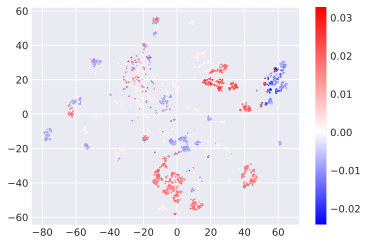

In [113]:
plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], 0.3, 
            c=_progress_scores, 
            norm=MidpointNormalize(midpoint=0),
            cmap='bwr')
plt.colorbar()
plt.show()

In [114]:
# print(train_summary.iloc[left_e - 1].frames, train_summary.iloc[right_e - 1].frames)

In [115]:
perp_fnx = lambda x: np.exp(scipy.stats.entropy(x)) / len(x)

In [116]:
# _progress_scores = teacher._replay.info["progress_scores"]
# _p = np.power(_progress_scores, 0.7)
# _p = np.exp(_p) / np.exp(_p).sum()
perp_fnx(teacher._replay.info["p"])

0.9429082592901442

In [117]:
_p = boltzmann(teacher._replay.info["_progress_scores"], T=0.0001)
perp_fnx(_p)

0.35458043610610723

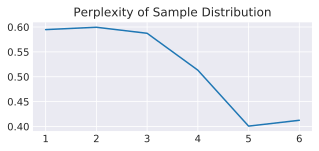

In [295]:
# plt.figure(figsize=(5,2))
# plt.plot([i[0] for i in perplexity], [i[1] for i in perplexity])
# plt.title("Perplexity of Sample Distribution")
# plt.show()

# Check Progress Scores Correctly Computed

In [26]:
bs = 1

In [27]:
_sample_batch = teacher._replay.get_transitions(range(100, 100+bs), 
                                                num_steps=teacher._train_params["num_steps"])

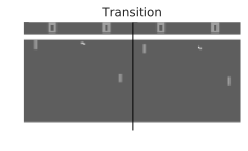

In [28]:
plot_transition(_sample_batch)

In [29]:
teacher._model._compute_naive_grads_norm(_sample_batch)

array([[[0.06660379, 0.00921871],
        [0.09609506, 0.03165007],
        [0.04300689, 0.02530165],
        [0.06209406, 0.01417731],
        [0.02845156, 0.01577744]]])

In [30]:
teacher._model._compute_naive_progress_scores(_sample_batch)

array([[[-5.79789514e-04, -4.96461098e-06],
        [ 1.23908359e-03,  5.02217154e-05],
        [ 3.42374697e-05,  2.12484701e-05],
        [ 1.19333994e-03,  1.73068896e-04],
        [-1.12302034e-04,  1.78954360e-04]]])

In [31]:
_sample_batch = teacher._replay.get_transitions(range(100, 100+bs+1), 
                                                num_steps=teacher._train_params["num_steps"])

In [32]:
teacher._model.zero_lower_bias()
_ = teacher._model._progress_backward(_sample_batch)

In [33]:
print(teacher._model._compute_grads_norm(bs+1))
print(teacher._model._progress_computation(bs+1))
teacher._model.zero_grad()
teacher._model.revert_lower_bias()

[[[6.11261463e+00 7.96755999e-02]
  [7.30057836e-01 5.08720092e-02]
  [1.21077783e-01 2.20809486e-02]
  [6.20940588e-02 1.41773056e-02]
  [2.84515638e-02 1.57774389e-02]]

 [[7.18674622e+01 9.36763406e-01]
  [7.48490620e+00 5.22737265e-01]
  [1.12422371e+00 2.03855634e-01]
  [5.25876641e-01 1.15435377e-01]
  [2.74897844e-01 1.70803621e-01]]]
[[[-5.79797314e-04 -4.96462371e-06]
  [ 1.23908999e-03  5.02217008e-05]
  [ 3.42378771e-05  2.12484774e-05]
  [ 1.19334029e-03  1.73068896e-04]
  [-1.12302107e-04  1.78954360e-04]]

 [[ 3.71044269e-03  1.60565542e-05]
  [-4.36684070e-03 -5.26723161e-04]
  [-4.51354636e-03 -1.02251105e-03]
  [ 2.74775503e-03 -3.18815652e-03]
  [-2.73027364e-03 -1.67963048e-03]]]


# Visualize Episodes

In [161]:
episode_num = find_episode_with_highest_rewards(train_summary)
episode_num = 8000

steps            274
total_rew         35
frames       1938283
Name: 8798, dtype: int64


In [164]:
episode = load_episode(episode_num)
display_episode(episode)